<a href="https://colab.research.google.com/github/AgishevDm/depression/blob/main/DEPRESSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Определение депрессии у студентов**

  Приложение для определния вероятности депрессии у студентов при помощи методов машинного обучения.

  Для обучения модели был использован открытый набор данных: https://www.kaggle.com/code/yashmehta648/student-depression-prediction

  Для использования приложения поэтапно запустите необходимые модули для устновки компонентов, обучения модели и запуска интерфейса

# **Установка**


# Установка библиотек

In [1]:
import subprocess
import time
from IPython.display import HTML, display

def install_packages_with_enhanced_progress(packages):

    num_packages = len(packages)
    start_time = time.time()
    block_height = "20px"

    # HTML для стилизованного индикатора прогресса на основе блоков
    def create_block_progress_html(percentage):
        num_blocks = 15
        filled_blocks = int(percentage / (100 / num_blocks))
        blocks = ''.join([f'<span style="color: green; padding-right: 2px; height: {block_height}; display: inline-block; vertical-align: middle;">█</span>' for _ in range(filled_blocks)]) + \
                 ''.join([f'<span style="color: lightgrey; padding-right: 2px; height: {block_height}; display: inline-block; vertical-align: middle;">█</span>' for _ in range(num_blocks - filled_blocks)])
        return f"""
        <div style="font-family: monospace; font-size: 16px; background-color: transparent;">
            {blocks} {percentage:.1f}%
        </div>
        """

    progress_display = display(HTML(create_block_progress_html(0)), display_id=True)

    try:
        for i, package in enumerate(packages):
            process = subprocess.Popen(['pip', 'install', package],
                                     stdout=subprocess.PIPE,
                                     stderr=subprocess.PIPE) # Запускаем pip install как отдельный процесс

            while process.poll() is None:
                time.sleep(0.1)

                overall_percentage = min(100.0, ((i / num_packages) * 100) + ((time.time() - start_time)/2) )
                progress_display.update(HTML(create_block_progress_html(overall_percentage))) # Обновляем индикатор прогресса

            stdout, stderr = process.communicate()

            if process.returncode != 0:
                print(f"Ошибка при установке {package}: {stderr.decode()}")
                raise Exception(f"Установка не удалась для {package}")

    except Exception as e:
        progress_display.update(HTML("<div style='color: red;'>Установка не удалась! Проверьте логи ошибок.</div>"))
        print(f"Общая установка не удалась: {e}")
        return

    progress_display.update(HTML("<div style='color: green;'>Установка завершена!</div>"))

# Список пакетов для установки
packages = [
    "tensorflow",
    "kagglehub",
    "pandas",
    "opendatasets",
    "dask[dataframe]",
    "scikit-learn",
    "matplotlib",
    "seaborn",
    "numpy",
    "ipywidgets"
]

install_packages_with_enhanced_progress(packages)

#Импорт библиотек

In [3]:
# Стандартные библиотеки
import os
import re
import time
import warnings
from datetime import datetime

# Для данных
import kagglehub
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import pexpect

# Машинное обучение и обработка данных
from sklearn.decomposition import PCA
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                        GradientBoostingClassifier,
                        HistGradientBoostingClassifier,
                        RandomForestClassifier)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import KFold, cross_val_score, learning_curve, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Визуализация и интерфейсы
import io
import joblib
from contextlib import redirect_stdout
import tkinter as tk
from matplotlib.animation import FuncAnimation
from tkinter import ttk, messagebox
from IPython.display import HTML, clear_output, display
from ipywidgets import Dropdown, FloatSlider, IntSlider, RadioButtons, interact, interactive, widgets

#Загрузка датасета

In [4]:
# Запуск процесса загрузки
child = pexpect.spawn('python -c "import opendatasets as od; od.download(\'https://www.kaggle.com/datasets/hopesb/student-depression-dataset\', force=True )"')

# Ожидаем первый запрос на логин и автоматически вводим
child.expect('Your Kaggle username:')
child.sendline('dmytrt')

# Ожидаем запрос пароля и вводим ключ
child.expect('Your Kaggle Key:')
child.sendline('17165469')

# Ждем завершения процесса
child.expect(pexpect.EOF)

# Загрузка данных и вывод первых 5 строк набора данных
dep_df = pd.read_csv("student-depression-dataset/Student Depression Dataset.csv")
dep_df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [5]:
# Размер датасета
dep_df.shape

(27901, 18)

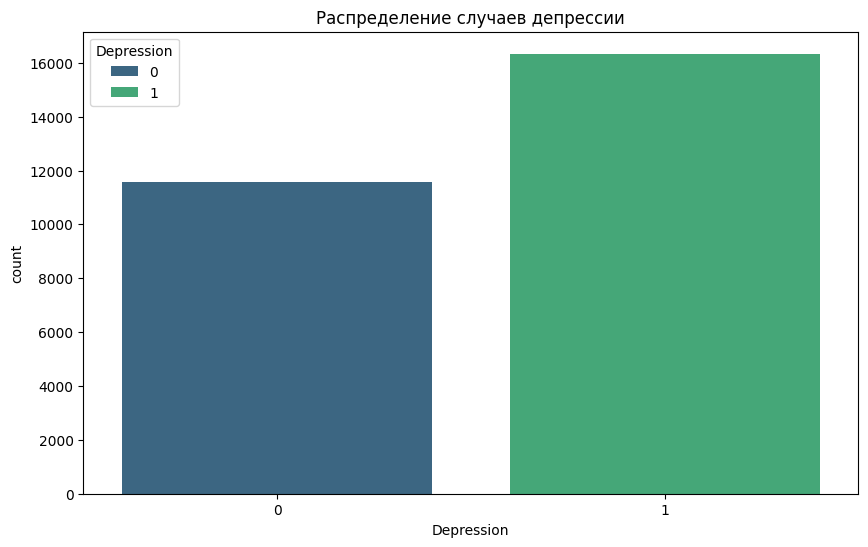

In [6]:
# Распределение случаев депрессии
plt.figure(figsize=(10, 6))
sns.countplot(
    x='Depression',
    hue='Depression',
    data=dep_df,
    palette='viridis',
    legend=True
)
plt.title('Распределение случаев депрессии')
plt.show()

# **Обучение модели**

# Предобработка и визуализация данных


✏️ Создание гистограмм для сравнения распределения категориальных признаков по значениям целевой переменной Depression



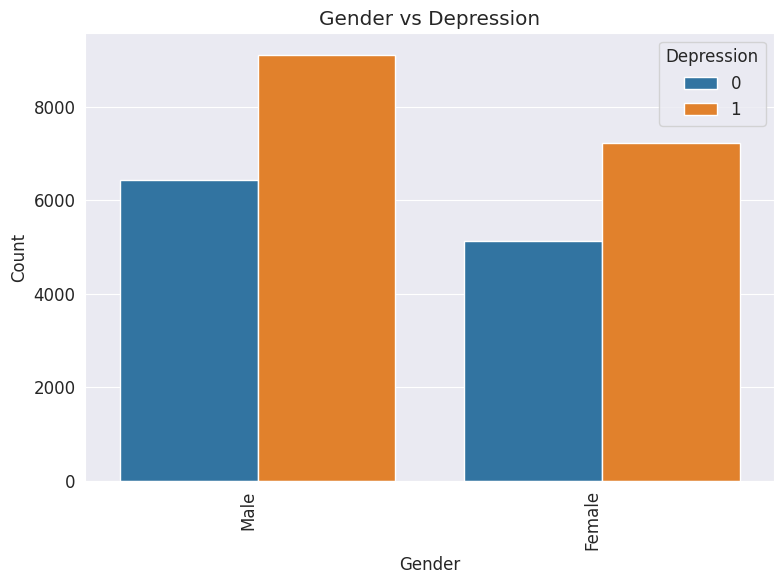

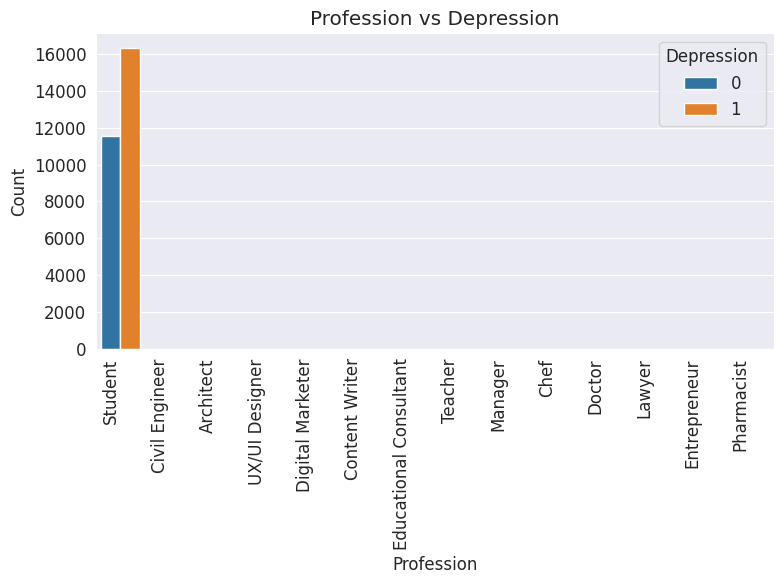

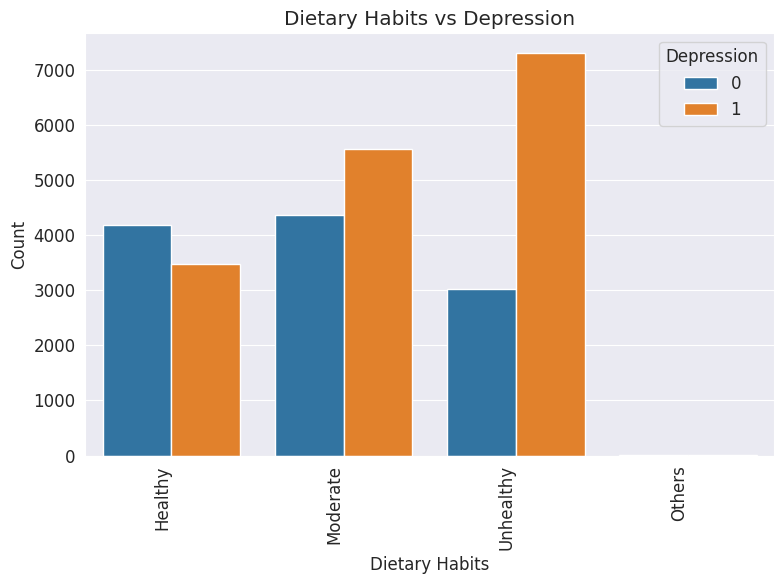

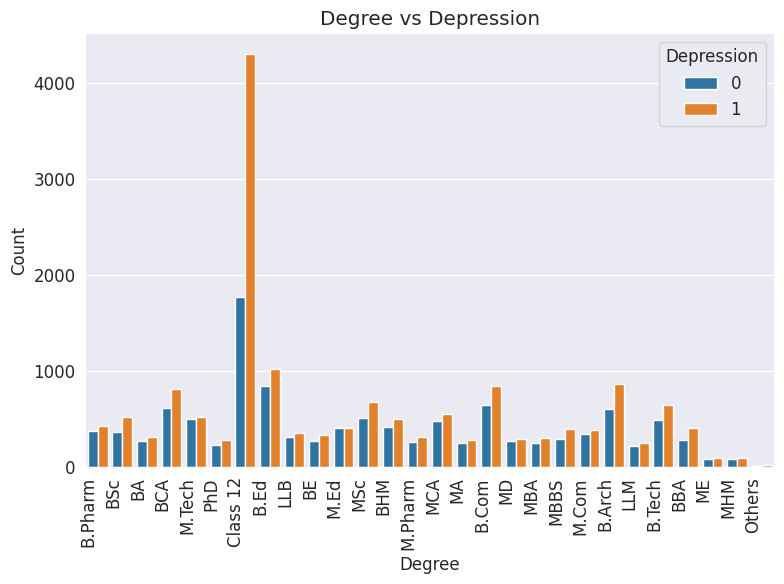

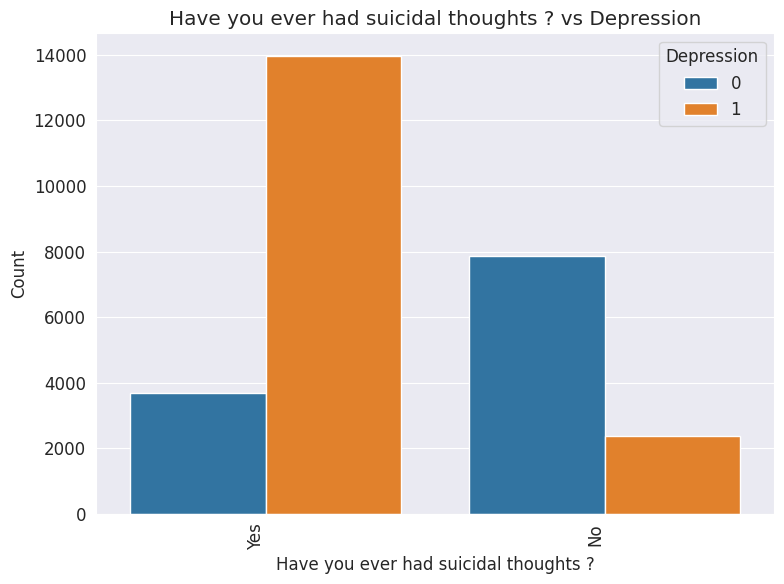

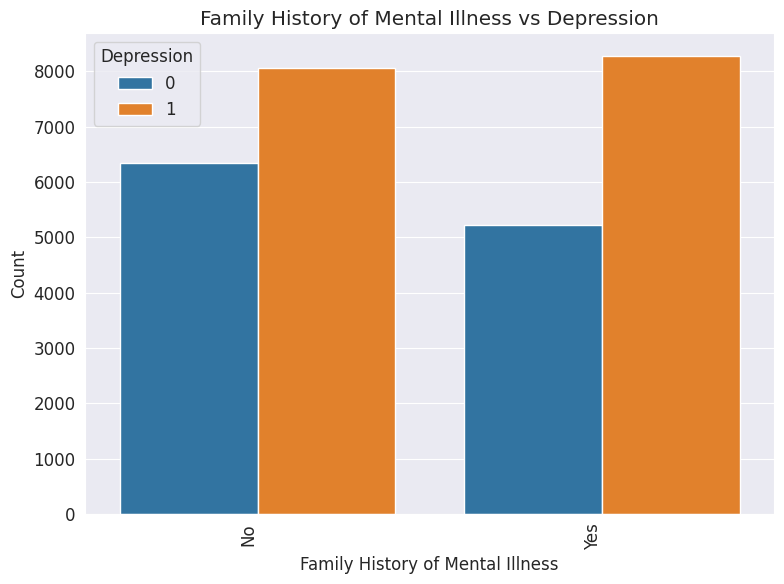

In [7]:
print("✏️ Создание гистограмм для сравнения распределения категориальных признаков по значениям целевой переменной Depression\n")
# Настройки

sns.set_style('darkgrid')
plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (12, 8),
    'figure.facecolor': 'white'
})
# Предобработка данных
dep_df = dep_df.drop(['City'], axis=1)
def convert_sleep_duration(sleep_duration):
    try:
        cleaned = re.sub(r'[^\d-]', '', str(sleep_duration))
        matches = re.findall(r'\d+', cleaned)
        if len(matches) == 2:
            return (int(matches[0]) + int(matches[1])) / 2
        return int(matches[0]) if matches else np.nan
    except:
        return np.nan

dep_df['Sleep Duration'] = dep_df['Sleep Duration'].apply(convert_sleep_duration)
dep_df['Sleep Duration'] = dep_df['Sleep Duration'].fillna(dep_df['Sleep Duration'].median())


#numeric_cols = ['Age', 'Academic Pressure', 'CGPA', 'Financial Stress', 'Sleep Duration']
numeric_cols =['Age', 'Academic Pressure', 'CGPA', 'Financial Stress', 'Sleep Duration']
dep_df[numeric_cols] = SimpleImputer(strategy='median').fit_transform(dep_df[numeric_cols])

categorical_cols = ['Gender', 'Profession', 'Dietary Habits', 'Degree',
                   'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

# Создание гистограмм для сравнения распределения категориальных признаков по значениям целевой переменной Depression
for column in categorical_cols:
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x=dep_df[column], hue='Depression', data=dep_df)
    plt.title(f'{column} vs Depression')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()

dep_df = pd.get_dummies(dep_df, columns=categorical_cols, drop_first=True)
dep_df = dep_df.drop(['id'], axis=1)

# Разделение данных
X = dep_df.drop(['Depression'], axis=1)
y = dep_df['Depression']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

✏️  Создание матрицы диаграмм рассеивания для анализа взаимосвязи между числовыми признаками и целевой переменной Depression



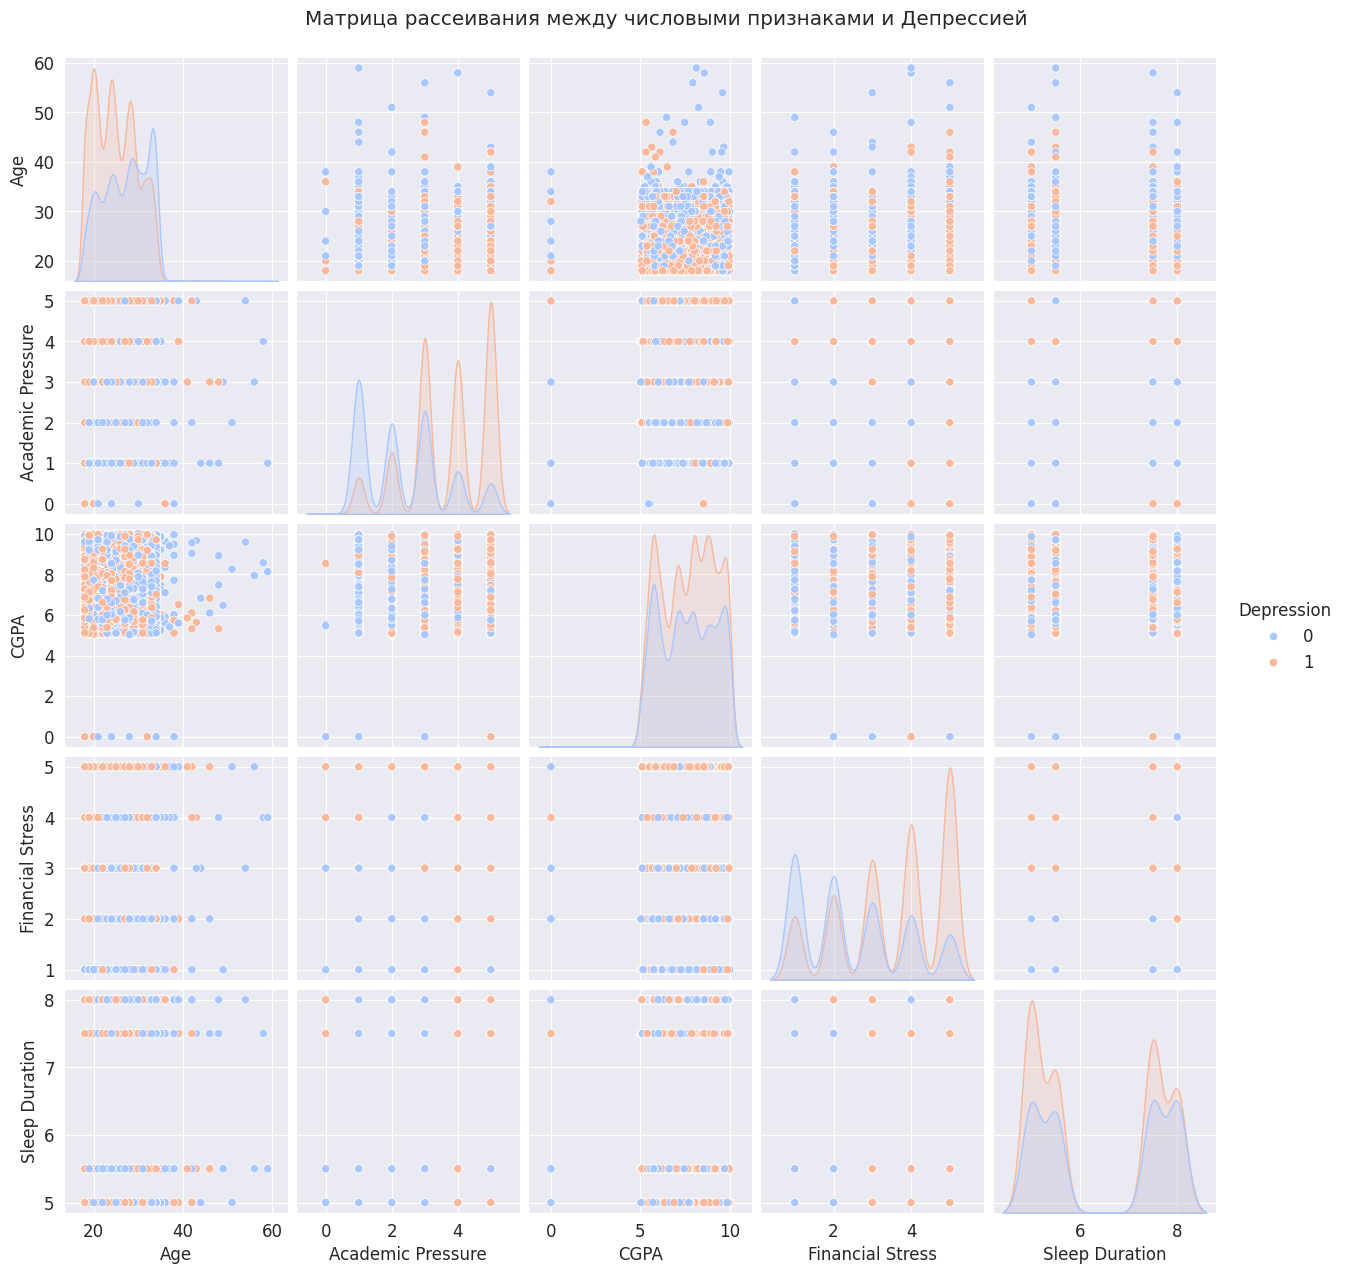

In [8]:
# Создание матрицы диаграмм рассеивания для анализа взаимосвязи между числовыми признаками и целевой переменной Depression
print("✏️  Создание матрицы диаграмм рассеивания для анализа взаимосвязи между числовыми признаками и целевой переменной Depression\n")
g = sns.pairplot(dep_df[['Age', 'Academic Pressure', 'CGPA', 'Financial Stress', 'Sleep Duration', 'Depression']], hue='Depression', palette='coolwarm')
g.fig.suptitle("Матрица рассеивания между числовыми признаками и Депрессией", y=1.02)
plt.show()

✏️  Создание матрицы корреляции



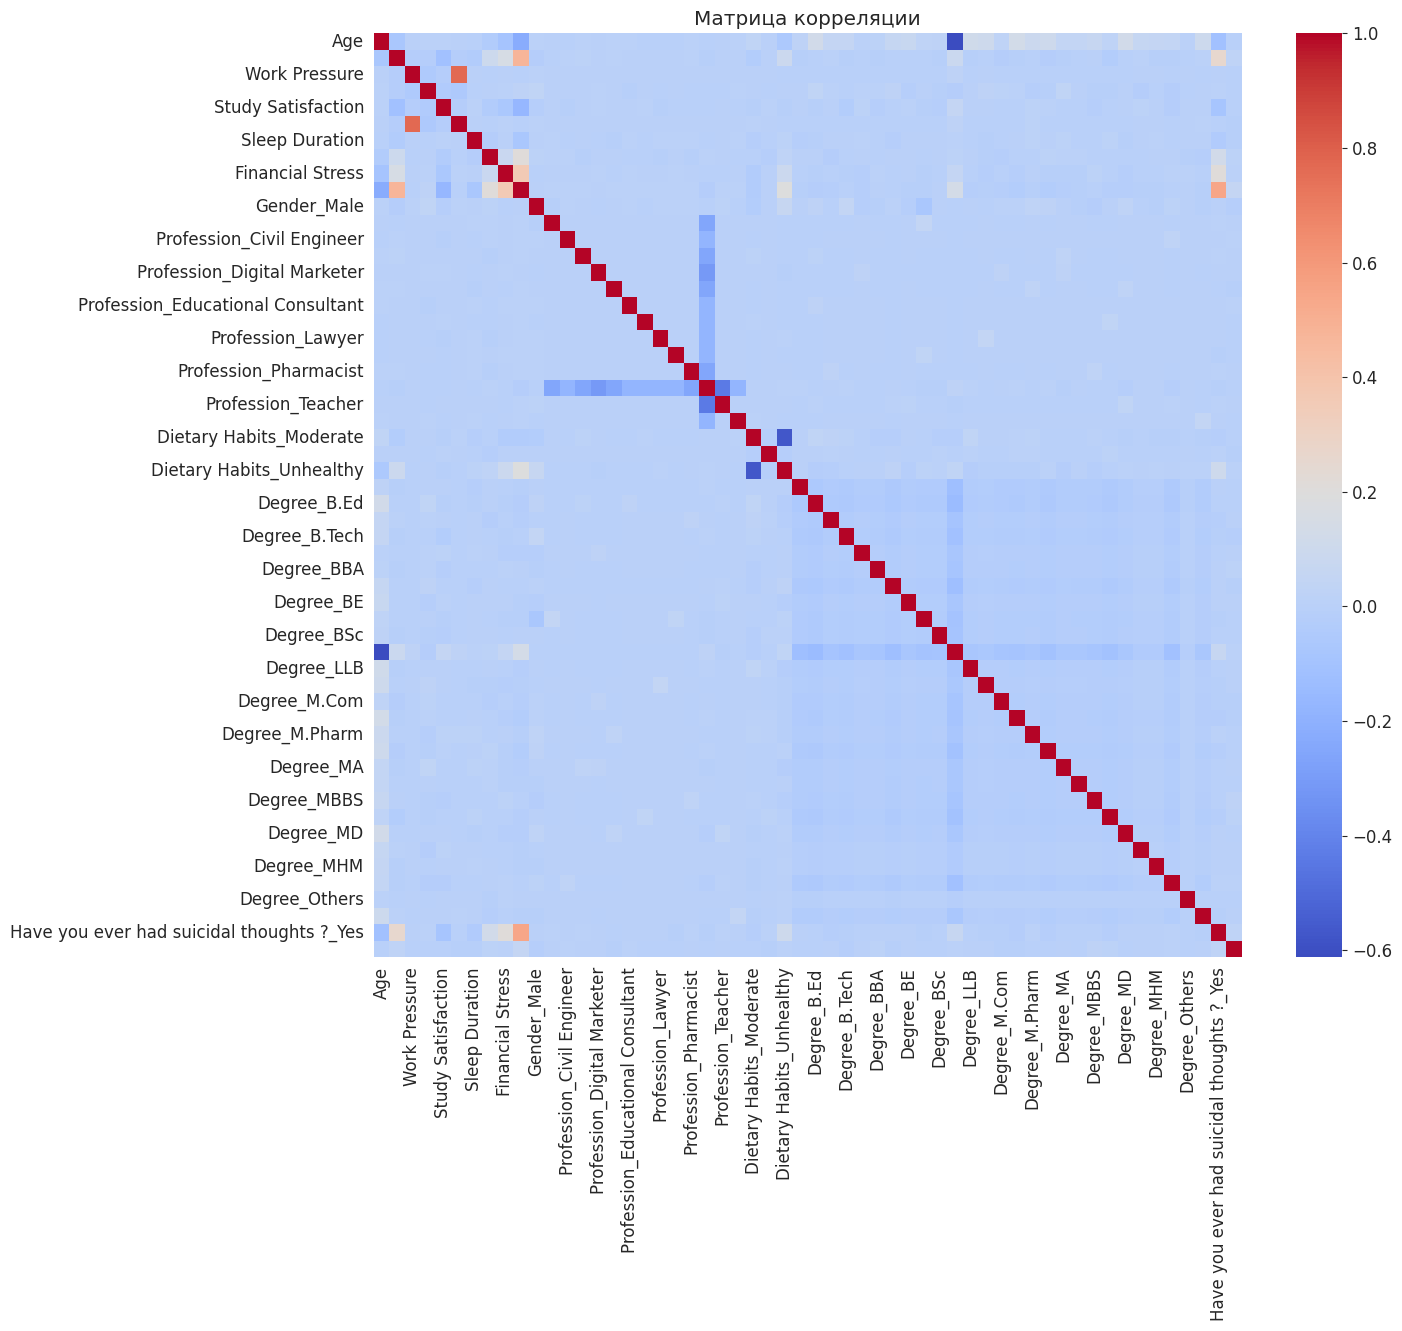

In [ ]:
# Матрица корреляции
print("✏️  Создание матрицы корреляции\n")
plt.figure(figsize=(14, 12))
corr = dep_df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

✏️  Создание даграммы важности признаков для определения наличия депрессии



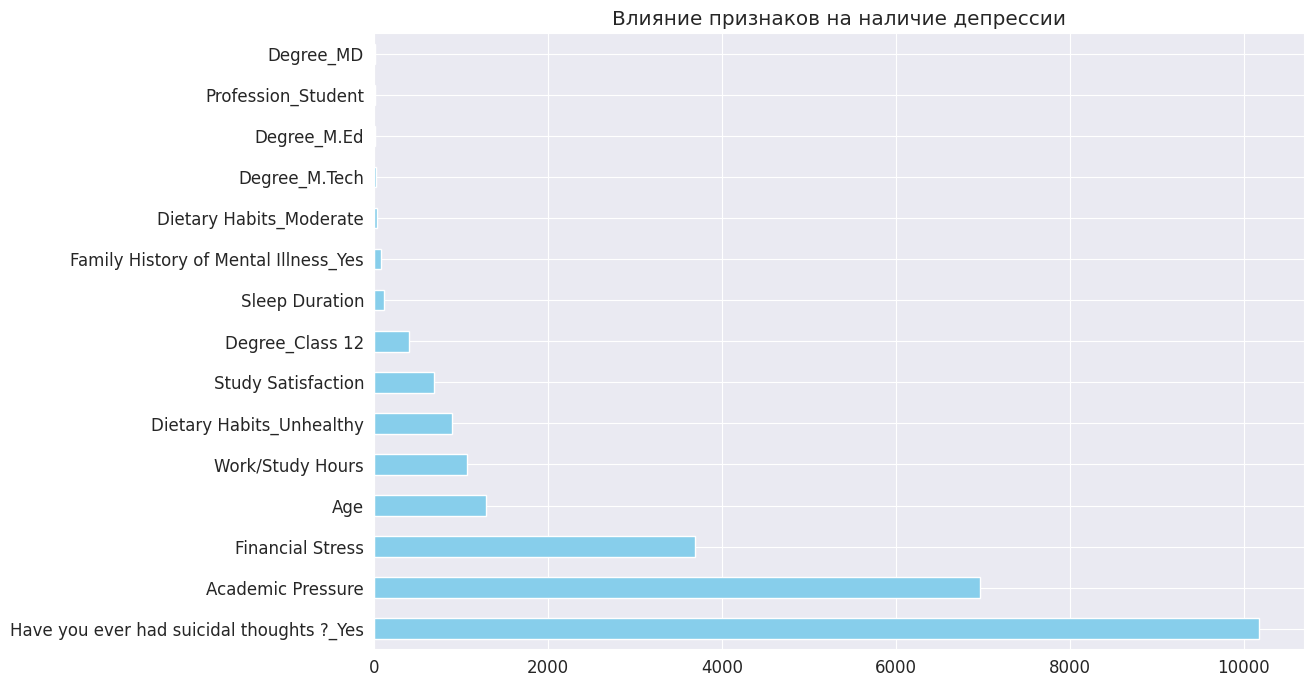

In [ ]:
# Анализ важности признаков
print("✏️  Создание даграммы важности признаков для определения наличия депрессии\n")
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
selected_features = X.columns[selector.get_support()]

plt.figure(figsize=(12, 8))
pd.Series(selector.scores_, index=X.columns).nlargest(15).plot(kind='barh', color='skyblue')
plt.title('Влияние признаков на наличие депрессии')
plt.show()

# Сравнение моделей

In [ ]:
# Класс для прогресса
class ProgressAnimator:
    def __init__(self, model_name, total=100):
        self.model_name = model_name
        self.total = total
        self.start_time = datetime.now()
        self.last_progress = 0

    def get_color(self, progress):
        r = int(255 * (1 - progress/100))
        g = int(255 * (progress/100))
        return f"\033[38;2;{r};{g};0m"

    def update(self, current, total_epochs):
        progress = min(100, int(100 * (current + 1) / self.total))
        if progress == self.last_progress:
            return
        self.last_progress = progress

        color = self.get_color(progress)
        elapsed = datetime.now() - self.start_time
        bar = '█' * int(progress / 2) + ' ' * (50 - int(progress / 2))
        epoch_str = f'Epochs: {current+1}/{total_epochs}'
        time_str = f' | Time: {elapsed.seconds}s'
        print(f'\r{color}➤ {self.model_name:25} [{bar}] {progress}% | {epoch_str}{time_str}', end='')


# Обучение моделей
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "SVM": SVC(probability=True, random_state=42, class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": XGBClassifier(n_estimators=150, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(num_leaves=31, random_state=42, verbose=-1)
}

trained_models = {}
results = []
confusion_matrices = []
print("\n👾 Начало обучения моделей:")
for name, model in models.items():
    animator = ProgressAnimator(name, total=500)
    start_time = time.time()
    epochs = 500

    try:
        if hasattr(model, 'partial_fit'):
            for epoch in range(epochs):
                model.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))
                animator.update(epoch, epochs)
                time.sleep(0.01)
        else:
            for epoch in range(epochs):
                if epoch == 0:
                    model.fit(X_train_scaled, y_train)
                animator.update(epoch, epochs)
                time.sleep(0.01)
    except Exception as e:
        print(f"\n⚠ Ошибка при обучении {name}: {str(e)}")

    train_time = time.time() - start_time
    print(f'\033[0m\n✅ Модель "{name}" обучена за {train_time:.1f} сек.')

    y_pred = model.predict(X_val_scaled)
    y_proba = model.predict_proba(X_val_scaled)[:,1] if hasattr(model, 'predict_proba') else [0]*len(y_val)

    cm = confusion_matrix(y_val, y_pred)
    confusion_matrices.append((name, cm))

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1': f1_score(y_val, y_pred),
        'AUC': roc_auc_score(y_val, y_proba) if hasattr(model, 'predict_proba') else 0.5,
        'Time': f'{train_time:.1f}s'
    }
    results.append(metrics)
    trained_models[name] = model


👾 Начало обучения моделей:
➤ Logistic Regression       [██████████████████████████████████████████████████] 100% | Epochs: 500/500 | Time: 5s
✅ Модель "Logistic Regression" обучена за 5.2 сек.
➤ Random Forest             [██████████████████████████████████████████████████] 100% | Epochs: 500/500 | Time: 8s
✅ Модель "Random Forest" обучена за 8.7 сек.
➤ SVM                       [██████████████████████████████████████████████████] 100% | Epochs: 500/500 | Time: 217s
✅ Модель "SVM" обучена за 217.6 сек.
➤ KNN                       [██████████████████████████████████████████████████] 100% | Epochs: 500/500 | Time: 5s
✅ Модель "KNN" обучена за 5.1 сек.
➤ XGBoost                   [██████████████████████████████████████████████████] 100% | Epochs: 500/500 | Time: 5s
✅ Модель "XGBoost" обучена за 5.9 сек.
➤ LightGBM                  [██████████████████████████████████████████████████] 100% | Epochs: 500/500 | Time: 5s
✅ Модель "LightGBM" обучена за 5.6 сек.


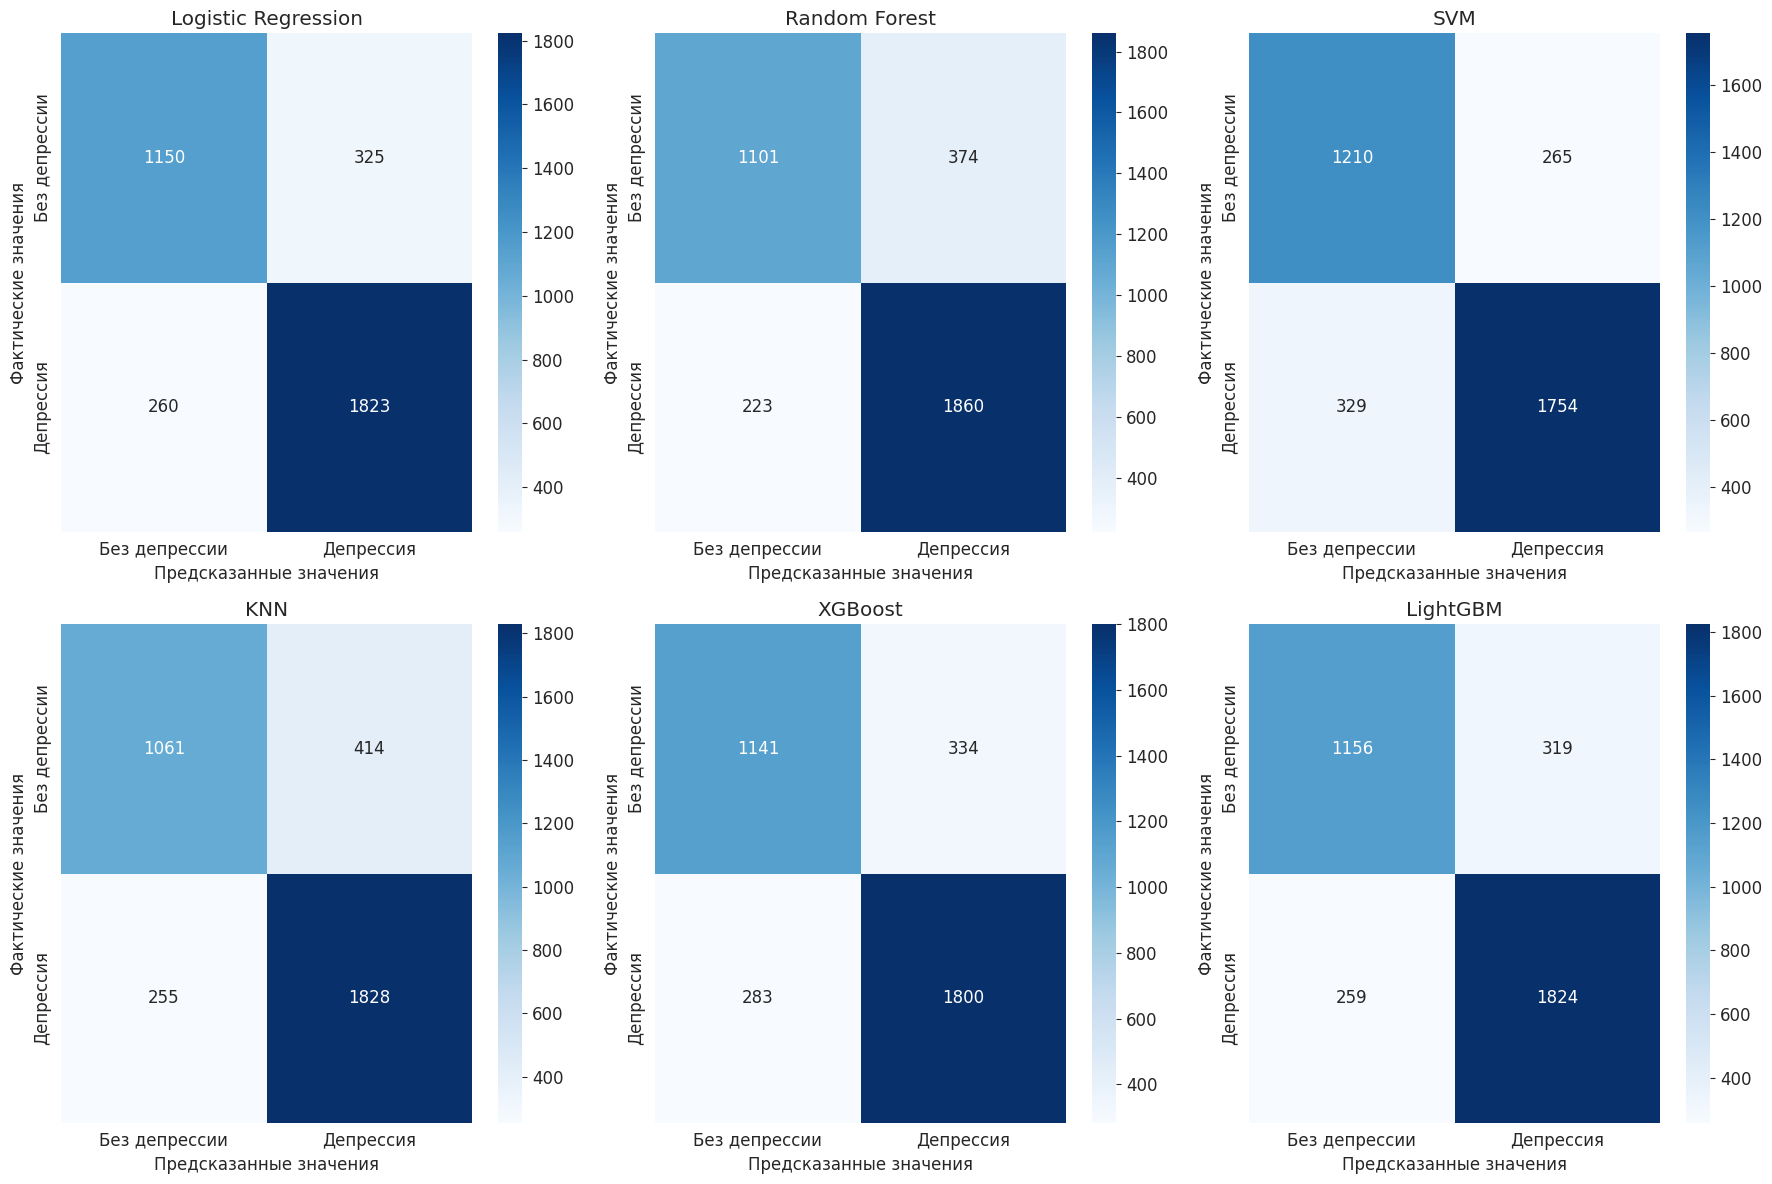

In [ ]:
# Матрицы ошибок
plt.figure(figsize=(18, 12))
for i, (name, cm) in enumerate(confusion_matrices, 1):
    plt.subplot(2, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Без депрессии', 'Депрессия'],
                yticklabels=['Без депрессии', 'Депрессия'])
    plt.title(f'{name}')
    plt.ylabel('Фактические значения')
    plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.show()

In [ ]:
# Таблица результатов обученных моделей
results_df = pd.DataFrame(results).sort_values('F1', ascending=False)
print("\n📈 Результаты сравнения моделей:")
display(results_df.style.background_gradient(cmap='Blues', subset=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']))

best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
print(f"\n🚀 Лучшая модель: {best_model_name} (F1-score: {results_df.iloc[0]['F1']:.3f})")


📈 Результаты сравнения моделей:


,Model,Accuracy,Precision,Recall,F1,AUC,Time
5,LightGBM,0.837549,0.851143,0.875660,0.863228,0.915496,5.6s
0,Logistic Regression,0.835582,0.848696,0.875180,0.861735,0.913967,5.2s
1,Random Forest,0.832209,0.832587,0.892943,0.861710,0.911397,8.7s
2,SVM,0.833052,0.868747,0.842055,0.855193,0.912849,217.6s
4,XGBoost,0.826588,0.843486,0.864138,0.853687,0.903528,5.9s
3,KNN,0.811973,0.815343,0.877580,0.845318,0.871601,5.1s



🚀 Лучшая модель: LightGBM (F1-score: 0.863)


# Обучение и сохранение лучшей модели

In [ ]:
# Финальное обучение
print(f"\n🤖 Финальное обучение {best_model_name} (1000 эпох):")
animator = ProgressAnimator(best_model_name, total=1000)
learning_progress = []
X_combined = np.vstack([X_train_scaled, X_val_scaled])
y_combined = np.concatenate([y_train, y_val])

start_time = time.time()
for epoch in range(1000):
    if hasattr(best_model, 'partial_fit'):
        best_model.partial_fit(X_combined, y_combined, classes=np.unique(y_combined))
    else:
        if epoch == 0:
            best_model.fit(X_combined, y_combined)

    animator.update(epoch, 1000)
    time.sleep(0.02)

print(f'\033[0m\n✅ Финальное обучение завершено за {time.time()-start_time:.1f} сек. (1000 эпох)')
t = time.time()-start_time

# Сохранение модели
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\n💾 Модель успешно сохранена!")


🤖 Финальное обучение LightGBM (1000 эпох):
➤ LightGBM                  [██████████████████████████████████████████████████] 100% | Epochs: 1000/1000 | Time: 20s
✅ Финальное обучение завершено за 20.7 сек. (1000 эпох)

💾 Модель успешно сохранена!


In [ ]:
# Результаты финального обучения на тестовых данных
final_metrics = {
    'Model': f'{best_model_name} (FINAL)',
    'Accuracy': accuracy_score(y_test, best_model.predict(X_test_scaled)),
    'Precision': precision_score(y_test, best_model.predict(X_test_scaled)),
    'Recall': recall_score(y_test, best_model.predict(X_test_scaled)),
    'F1': f1_score(y_test, best_model.predict(X_test_scaled)),
    'AUC': roc_auc_score(y_test, best_model.predict_proba(X_test_scaled)[:,1]),
    'Time': f'{t:.1f}s'
}

# Отдельный DataFrame для финального результата
final_results_df = pd.DataFrame([final_metrics])

# Вывод таблицы
print("\n🏆 Результаты финальной модели после обучения:")
display(final_results_df.style.background_gradient(
    cmap='Greens',
    subset=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
))


🏆 Результаты финальной модели после обучения:


,Model,Accuracy,Precision,Recall,F1,AUC,Time
0,LightGBM (FINAL),0.851911,0.870620,0.877717,0.874154,0.924990,20.7s


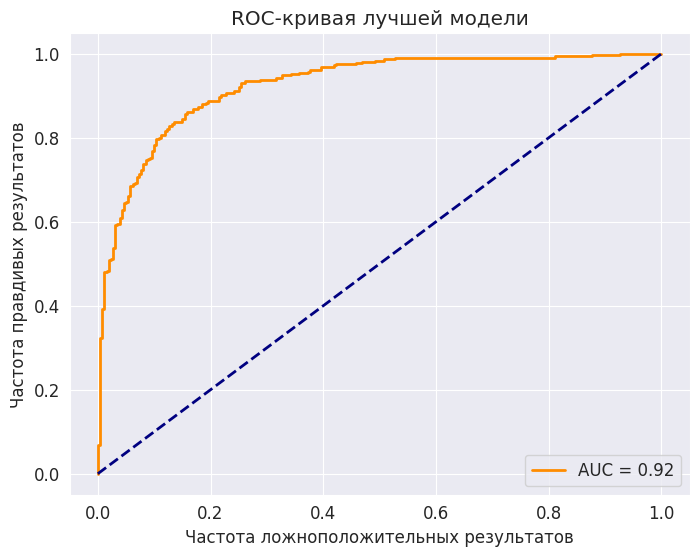

In [ ]:
# ROC-кривая
y_proba = best_model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Частота ложноположительных результатов')
plt.ylabel('Частота правдивых результатов')
plt.title('ROC-кривая лучшей модели')
plt.legend(loc="lower right")
plt.show()

# **Интерфейс для использования модели**

# Загрузка модели. Интерфейс. Обработчики событий

In [ ]:
# Загрузка обученной модели
try:
    model = joblib.load('best_model.pkl')
    scaler = joblib.load('scaler.pkl')
    print("✅ Модель успешно загружена")
except Exception as e:
    print(f"⚠ Ошибка загрузки модели: {e}")
    raise

# Стили
styles = """
<style>
    /* Анимация кнопок */
    .jupyter-button {
        transition: all 0.3s ease !important;
        position: relative;
        overflow: hidden;
        border-radius: 8px !important;
    }

    .jupyter-button:before {
        content: '';
        position: absolute;
        top: 0;
        left: 0;
        width: 100%;
        height: 100%;
        background: rgba(255,255,255,0.2);
        opacity: 0;
        transition: opacity 0.3s ease;
    }

    .jupyter-button:hover:before {
        opacity: 1;
    }

    /* Стили для ползунков */
    .widget-slider .ui-slider-handle {
        transition: transform 0.2s ease, box-shadow 0.2s ease;
    }

    .widget-slider .ui-slider-handle:hover {
        transform: scale(1.2);
        box-shadow: 0 0 10px rgba(66,165,245,0.5);
    }
</style>
"""

# Шапка приложения
header = widgets.HTML(
    "<div style='text-align:center; padding:20px; margin-bottom:20px;'>"
    "<h1 style='color:#FFFFFF;'>📊 Тест на риск депрессии</h1>"
    "<p style='color:#666; max-width:600px; margin:0 auto;'>"
    "Анонимный тест для оценки психологического состояния</p>"
    "</div>"
)

# Сообщение благодарности
thank_you_message = widgets.HTML(
    "<div style='text-align:center; padding:40px; color:#2c3e50;'>"
    "<h2>🍃 Спасибо за прохождение теста!</h2>"
    "<p style='color:#666'>Берегите свое психическое здоровье и не стесняйтесь обращаться за помощью.</p>"
    "</div>",
    layout={'display': 'none'}  # Изначально скрыт
)

# Футер
footer = widgets.HTML(
    "<div style='text-align:center; margin-top:20px; color:#666;'>"
    "<p>Круглосуточная психологическая помощь: 8 800 2000 122</p>"
    "</div>"
)

# Виджеты (слайдер и радиобатон)
def create_styled_slider(description, **kwargs):
    return FloatSlider(
        **kwargs,
        description=description,
        style={'description_width': 'initial'},
        layout={'width': '80%', 'margin': '10px auto'},
        continuous_update=False
    )

def create_styled_radio(description, options):
    return RadioButtons(
        options=options,
        description=description,
        style={'description_width': 'initial'},
        layout={'width': '80%', 'margin': '10px auto'}
    )

# Создание виджетов
widgets_dict = {
    'Age': create_styled_slider(
        '👶 Возраст:',
        value=17, min=15, max=60, step=1
    ),
    'Academic Pressure': create_styled_slider(
        '📚 Учебная нагрузка (0-10 где 0 - нет нагрузки, 10 - экстремальная):',
        value=5, min=0, max=10, step=0.05
    ),
    'CGPA': create_styled_slider(
        '🎓 Средний балл (CGPA по шкале 0-5):',
        value=5, min=0, max=5, step=0.01
    ),
    'Financial Stress': create_styled_slider(
        '💸 Финансовый стресс (0-10 где 0 - нет проблем, 10 - критическое положение):',
        value=5, min=0, max=10, step=0.1
    ),
    'Work Pressure': create_styled_slider(
        '💼 Рабочая нагрузка (0-10 где 0 - нет нагрузки, 10 - непосильная):',
        value=5, min=0, max=10, step=0.1
    ),
    'Study Satisfaction': create_styled_slider(
        '😊 Удовлетворенность учебой (0-10 где 0 - полная неудовлетворенность):',
        value=5, min=0, max=10, step=0.1
    ),
    'Sleep Duration': create_styled_slider(
        '😴 Продолжительность сна (часов в сутки):',
        value=7, min=0, max=24, step=0.5
    ),
    'Gender_Male': create_styled_radio(
        '👤 Пол:',
        [('Мужской', 1), ('Женский', 0)]
    ),
    'Profession_Working': create_styled_radio(
        '👔 Основной род деятельности:',
        [('Работающий', 1), ('Студент', 0)]
    ),
    'Dietary Habits_Vegetarian': create_styled_radio(
        '🥦 Диетические привычки:',
        [('Здорове питание', 1), ('Нездоровое питание', 0)]
    ),
    'Degree': Dropdown(
        options=[('Бакалавр', (0,0)), ('Магистр', (1,0)), ('Аспирант', (0,1))],
        description='🎓 Образовательная степень:',
        style={'description_width': 'initial'},
        layout={'width': '80%', 'margin': '10px auto'}
    ),
    'Have you ever had suicidal thoughts ?_Yes': create_styled_radio(
        '💔 Были ли у вас суицидальные мысли?:',
        [('Да', 1), ('Нет', 0)]
    ),
    'Family History of Mental Illness_Yes': create_styled_radio(
        '🧬 Есть ли в семье история психических заболеваний?:',
        [('Да', 1), ('Нет', 0)]
    )
}

# Функция отображения результатов
def show_results(prediction, proba):
    risk_class = "risk-high" if prediction == 1 else "risk-low"
    result_html = f"""
    <div class="{risk_class} recommendation-box">
        <h3 style="color:{"#ff4444" if prediction == 1 else "#44aa44"}; margin-top:0;">
            {'⚠️ Высокий риск депрессии' if prediction == 1 else '✅ Низкий риск'}
        </h3>
        <div style="font-size: 24px; margin: 15px 0; color: {"#ff4444" if prediction == 1 else "#44aa44"}">
            Вероятность: {proba:.1f}%
        </div>
        <h4 style="margin-bottom: 10px;">📋 Рекомендации:</h4>
        <ul style="padding-left: 20px; margin: 0;">
    """

    recommendations = []
    if prediction == 1:
        recommendations.append("🚨 Срочно обратитесь к психологу или психотерапевту")
        recommendations.append("📞 Позвоните на горячую линию психологической помощи: 8 800 2000 122")
        recommendations.append("🧘 Практикуйте техники глубокого дыхания и релаксации")
        if proba > 75:
            recommendations.append("❗️ Немедленно обратитесь в ближайший медицинский центр")
            recommendations.append("⚕️ Запишитесь на срочную консультацию специалиста")
        else:
            recommendations.append("📅 Запланируйте регулярные консультации с психологом")
            recommendations.append("🏃 Увеличьте физическую активность")
    else:
        recommendations.append("👍 Продолжайте поддерживать здоровый баланс работы и отдыха")
        recommendations.append("📅 Регулярно проверяйте свое эмоциональное состояние")
        recommendations.append("🍎 Соблюдайте режим здорового питания и сна")

    result_html += "\n".join([f"<li>{r}</li>" for r in recommendations])
    result_html += "</ul></div>"
    display(HTML(styles + result_html))

# Контейнер вопросов
questions_box = widgets.VBox(
    [widgets_dict[k] for k in widgets_dict],
    layout=widgets.Layout(
        width='80%',
        margin='20px auto',
        padding='20px',
        border='1px solid #eee',
        border_radius='8px',
        display='none'
    )
)

# Кнопки управления:
start_button = widgets.Button(
    description='Начать тестирование',
    button_style='success',
    icon='play',
    layout={'width': '300px', 'margin': '20px auto', 'justify_content': 'center'}
)

finish_button = widgets.Button(
    description='Завершить тестирование',
    button_style='warning',
    icon='flag-checkered',
    layout={'width': '300px', 'margin': '20px auto', 'justify_content': 'center','display': 'none'}
)

restart_button = widgets.Button(
    description='Пройти тест повторно',
    button_style='success',
    icon='refresh',
    layout={'width': '300px', 'margin': '20px auto',
        'justify_content': 'center', 'display': 'none'}
)

# Блок результатов
result_output = widgets.Output(layout={'display': 'none', 'justify_content': 'center'})

# Собираем интерфейс
app = widgets.VBox([
    header,
    start_button,
    questions_box,
    finish_button,
    result_output,
    thank_you_message,
    restart_button,
    footer
], layout=widgets.Layout(width='100%'))

# Функции управления интерфейсом
def reset_widgets():
    for name, widget in widgets_dict.items():
        if isinstance(widget, FloatSlider):
            widget.value = (widget.max + widget.min) / 2
        elif isinstance(widget, RadioButtons):
            widget.index = None
        elif isinstance(widget, Dropdown):
            widget.value = widget.options[0][1]
    result_output.clear_output()

def start_test(b):
    reset_widgets()
    start_button.layout.display = 'none'
    questions_box.layout.display = 'flex'
    finish_button.layout.display = 'flex'
    restart_button.layout.display = 'none'
    result_output.layout.display = 'none'

    for widget in widgets_dict.values():
        widget.disabled = False

def finish_test(b):
    data = {name: widget.value for name, widget in widgets_dict.items()}
    with result_output:
        result_output.clear_output()
        try:
            predict_depression(**data)
        except Exception as e:
            display(HTML(f"<div style='color:red; padding:20px;'>Ошибка: {str(e)}</div>"))

    questions_box.layout.display = 'none'
    finish_button.layout.display = 'none'
    result_output.layout.display = 'flex'
    restart_button.layout.display = 'flex'
    thank_you_message.layout.display = 'flex'

    for widget in widgets_dict.values():
        widget.disabled = True

def restart_test(b):
    thank_you_message.layout.display = 'none'
    start_test(b)

# Обработчики нажатия на кнопки
start_button.on_click(start_test)
finish_button.on_click(finish_test)
restart_button.on_click(restart_test)

# Функция прогнозирования
def predict_depression(**kwargs):
    try:
        data = {
            'Age': kwargs['Age'],
            'Academic Pressure': kwargs['Academic Pressure'],
            'CGPA': kwargs['CGPA'] * 2,
            'Financial Stress': kwargs['Financial Stress'],
            'Work Pressure': kwargs['Work Pressure'],
            'Study Satisfaction': kwargs['Study Satisfaction'],
            'Sleep Duration': kwargs['Sleep Duration'],
            'Gender_Male': kwargs['Gender_Male'],
            'Profession_Working': kwargs['Profession_Working'],
            'Dietary Habits_Vegetarian': kwargs['Dietary Habits_Vegetarian'],
            'Degree_Master': kwargs['Degree'][0],
            'Degree_PhD': kwargs['Degree'][1],
            'Have you ever had suicidal thoughts ?_Yes': kwargs['Have you ever had suicidal thoughts ?_Yes'],
            'Family History of Mental Illness_Yes': kwargs['Family History of Mental Illness_Yes']
        }

        input_df = pd.DataFrame([data], columns=X_train.columns)

        scaled_input = scaler.transform(input_df)
        prediction = model.predict(scaled_input)[0]
        proba = model.predict_proba(scaled_input)[0][1] * 100

        show_results(prediction, proba)

    except Exception as e:
        display(HTML(f"<div style='color:red; padding:20px;'>Ошибка: {str(e)}</div>"))

✅ Модель успешно загружена


# Запуск интерфейса

In [ ]:
# Запуск приложения
display(HTML(styles))
display(app)